# Seq2seq для машинного перевода

В этом блокноте рассматриваются некоторые подходы к задаче машинного перевода с помощью

* Рекуррентных сетей
* Рекуррентных сетей с механизмом внимания
* Трасформеров

Первый и последний подходы уже реализованы. Вам предлагается реализовать второй подход, а именно интегрировать механизм внимания в рекуррентную НС. Для лучшего понимания рекомендуем ознакомиться [со следющей статьей](https://arxiv.org/pdf/1409.0473). Какой конкретно тип механизма внимания реализовывать остается на выбор студенту.

Для оценок трех рассмотренных подходов реализовать метрику BLEU. В качестве тестовой выборки можно использовать валидационный набор. Или произвести требуемое разделение самостоятельно.

В качестве резюме (на 3 балла):

1. Разобраться в задаче и в коде
2. Добавить внимание к рекуррентной сети
3. Реализовать BLEU
4. Сравнить полученные 3 модели между собой.
5. **Опционально (+1 балл)**: продемонстрировать alignment между словами на исходном и целевом языках (аналогично Figure 3 в предложенной статье).
6. **Опционально (+1 балл)**: сравнить 3 полученных модели (по метрике) между собой на парах различной длины. Например, вычислить метрики на коротких, средних и длинных предложениях. Если средних/длинных предложений нет в выборке -- сгенерировать самостоятельно, например через LLM.

# Загрузка данных

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2025-06-04 12:01:47--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 172.217.204.207, 172.217.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.009s  

2025-06-04 12:01:47 (281 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('I was about to suggest the same thing.', '[start] Estaba a punto de sugerir lo mismo. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Векторизация пар**

In [ ]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

In [ ]:
real_vocab_size = target_vectorization.vocabulary_size()
print(f"Реальный размер словаря: {real_vocab_size}")

Реальный размер словаря: 15000


**Подготовка датасетов**

In [ ]:
batch_size = 16

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (16, 20)
inputs['spanish'].shape: (16, 20)
targets.shape: (16, 20)


# RNN сеть

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 222s 165ms/step - accuracy: 0.1520 - loss: 5.2623 - val_accuracy: 0.1561 - val_loss: 3.8936
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.1609 - loss: 3.8834 - val_accuracy: 0.1875 - val_loss: 3.2585
Epoch 3/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.1860 - loss: 3.3265 - val_accuracy: 0.2078 - val_loss: 2.8806
Epoch 4/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.2034 - loss: 2.9504 - val_accuracy: 0.2219 - val_loss: 2.6350
Epoch 5/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.2177 - loss: 2.6586 - val_accuracy: 0.2325 - val_loss: 2.4511
Epoch 6/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.2302 - loss: 2.4235 - val_accuracy: 0.2408 - val_loss: 2.3162
Epoch 7/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.2402 - loss: 2.2271 - val_accuracy: 0.2461 - val_loss: 2.2281
Epoch 8/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - ac

**Пример перевода с помощью RNN сети**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom spilled his drink.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[start] tom [UNK] su bebida [end]
-
Anything can happen on TV.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[start] cualquier cosa puede ver en la televisión [end]
-
This tree is about as tall as that one.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[start] este ár

# RNN + attention

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Attention, Concatenate
from tensorflow.keras.models import Model


In [ ]:
english_seq = source_vectorization(train_english_texts).numpy()
spanish_seq = target_vectorization(train_spanish_texts).numpy()

english_vocab_size = source_vectorization.vocabulary_size()
spanish_vocab_size = target_vectorization.vocabulary_size()


In [ ]:
max_seq_length = 30
encoder_input_data = pad_sequences(english_seq, maxlen=max_seq_length, padding='post')
decoder_input_data = pad_sequences(spanish_seq, maxlen=max_seq_length, padding='post')
decoder_target_data = np.zeros((len(spanish_seq), max_seq_length, spanish_vocab_size), dtype="float32")

for i, seq in enumerate(spanish_seq):
    for j, word_index in enumerate(seq):
        decoder_target_data[i, j, word_index] = 1.0

In [ ]:
source_vocab = source_vectorization.get_vocabulary()
source_index = dict(zip(source_vocab, range(len(source_vocab))))
target_vocab = target_vectorization.get_vocabulary()
target_index = dict(zip(target_vocab, range(len(target_vocab))))
index_target = dict(enumerate(target_vocab))


In [ ]:
embedding_dim = 32
hidden_units = 64

encoder_inputs = Input(shape=(None,), name="english")
x = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(x)

decoder_inputs = Input(shape=(None,), name="spanish")
x = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm_out, _, _ = LSTM(hidden_units, return_sequences=True, return_state=True)(x, initial_state=[state_h, state_c])

attention_out = Attention()([decoder_lstm_out, encoder_outputs])
context = Concatenate(axis=-1)([decoder_lstm_out, attention_out])

decoder_outputs = Dense(vocab_size, activation="softmax")(context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=20)


Epoch 1/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 112s 21ms/step - accuracy: 0.7055 - loss: 2.2679 - val_accuracy: 0.7573 - val_loss: 1.4809
Epoch 2/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.7652 - loss: 1.4326 - val_accuracy: 0.7931 - val_loss: 1.1870
Epoch 3/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8020 - loss: 1.1301 - val_accuracy: 0.8233 - val_loss: 0.9922
Epoch 4/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8327 - loss: 0.9144 - val_accuracy: 0.8410 - val_loss: 0.8741
Epoch 5/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8535 - loss: 0.7662 - val_accuracy: 0.8514 - val_loss: 0.8036
Epoch 6/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8683 - loss: 0.6615 - val_accuracy: 0.8582 - val_loss: 0.7592
Epoch 7/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8793 - loss: 0.5843 - val_accuracy: 0.8624 - val_loss: 0.7324
Epoch 8/20
5205/5205 ━━━━━━━━━━━━━━━━━━━━ 95s 18ms/step - accuracy: 0.8882 

In [ ]:
import numpy as np

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])

    # Инициализация начала перевода
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = model.predict(
            {
                "english": tokenized_input_sentence,
                "spanish": tokenized_target_sentence
            },
            verbose=0
        )

        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup.get(sampled_token_index, "[UNK]")

        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

    return decoded_sentence.replace("[start] ", "").replace(" [end]", "")


In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]

for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    print("-" * 30)
    print("Input:", input_sentence)
    print("Translation:", decode_sequence(input_sentence))


------------------------------
Input: Which do you prefer, white wine or red wine?
Translation: qué prefieres el vino más rojo o de vino
------------------------------
Input: What is your emergency?
Translation: cuál es tu estas oportunidad
------------------------------
Input: He was grateful for your help.
Translation: Él fue criado por ti tu ayuda
------------------------------
Input: I'll meet them at six.
Translation: me reuniré con los seis
------------------------------
Input: Where do they do that?
Translation: dónde están hechos
------------------------------
Input: I asked him about the accident.
Translation: le pedí acerca del accidente
------------------------------
Input: He got up at eight in the morning.
Translation: Él se levantó a las ocho por la mañana
------------------------------
Input: He spoke well of her son.
Translation: Él habló bien de su hijo
------------------------------
Input: I'm glad to hear it.
Translation: me alegro de escuchar
-----------------------

#  Aligment

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Attention, Concatenate, Dense

embedding_dim = 32
hidden_units = 64

# Encoder
encoder_inputs = Input(shape=(None,), name="english")
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(enc_emb)

# Decoder
decoder_inputs = Input(shape=(None,), name="spanish")
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs, _, _ = LSTM(hidden_units, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

# Attention
attention_layer = Attention(name="attention_layer")
attention_output = attention_layer([decoder_outputs, encoder_outputs])
concat_attention = Concatenate(axis=-1)([decoder_outputs, attention_output])

decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(concat_attention)

# Основная модель
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Модель для получения attention-выходов
attention_model = Model([encoder_inputs, decoder_inputs], attention_output)


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=1)

5205/5205 ━━━━━━━━━━━━━━━━━━━━ 1987s 381ms/step - accuracy: 0.7282 - loss: 1.8048 - val_accuracy: 0.7603 - val_loss: 1.4326


In [ ]:
# Входное английское предложение
test_sentence = "We must pay attention to the fact that no nation claimed sovereignty"

max_decoded_sentence_length = 10
# Преобразуем в токены
tokenized_input = source_vectorization([test_sentence])
decoded_sentence = "[start]"

# Постепенно строим target-вход для декодера
for i in range(max_decoded_sentence_length):
    tokenized_target = target_vectorization([decoded_sentence])

    # Получаем веса внимания с помощью attention_model
    attention_weights = attention_model.predict([tokenized_input, tokenized_target], verbose=0)

    # Получаем прогноз модели (основной)
    preds = model.predict([tokenized_input, tokenized_target], verbose=0)
    next_index = np.argmax(preds[0, i, :])
    next_token = target_vectorization.get_vocabulary()[next_index]

    decoded_sentence += " " + next_token
    if next_token == "[end]":
        break


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attention, source_tokens, target_tokens):
    attention = attention[0]  # убираем batch dim → (target_len, source_len)
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attention, cmap='viridis')

    ax.set_xticks(np.arange(len(source_tokens)))
    ax.set_yticks(np.arange(len(target_tokens)))

    ax.set_xticklabels(source_tokens, rotation=90)
    ax.set_yticklabels(target_tokens)

    ax.set_xlabel('Source')
    ax.set_ylabel('Target')
    plt.colorbar(cax)
    plt.show()


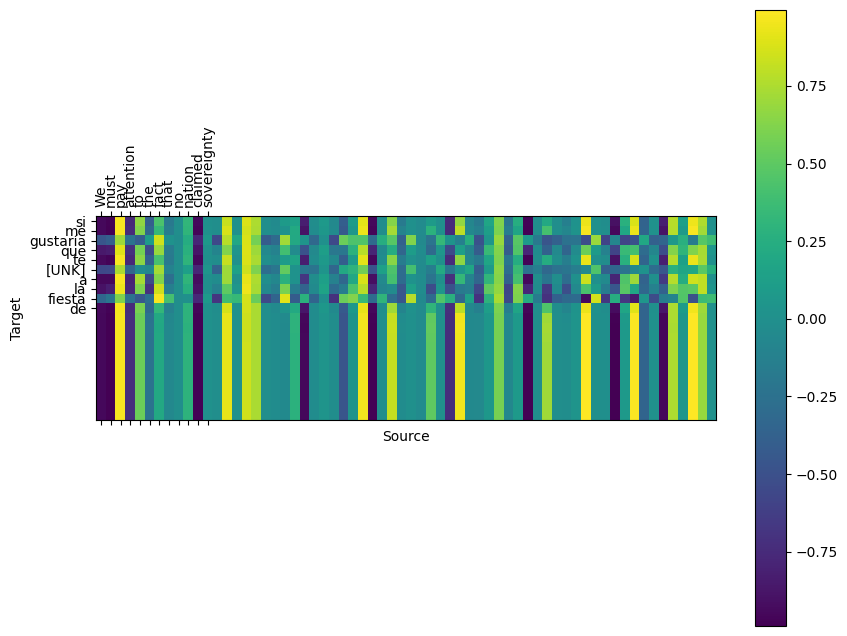

In [ ]:
source_tokens = test_sentence.split()
target_tokens = decoded_sentence.replace('[start]', '').replace('[end]', '').strip().split()

plot_attention(attention_weights, source_tokens, target_tokens)


# Трансформер

**Класс `TransformerDecoder`**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

**Слой PositionalEmbedding**

In [ ]:
import keras.ops as ops

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

**End-to-end Трансформер**

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


**Обучение**

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 99s 64ms/step - accuracy: 0.1601 - loss: 4.3580 - val_accuracy: 0.2478 - val_loss: 2.2782
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 75s 58ms/step - accuracy: 0.2507 - loss: 2.2767 - val_accuracy: 0.2745 - val_loss: 1.7672
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.2785 - loss: 1.7070 - val_accuracy: 0.2834 - val_loss: 1.5905
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.2924 - loss: 1.4112 - val_accuracy: 0.2874 - val_loss: 1.5238
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.3022 - loss: 1.2223 - val_accuracy: 0.2908 - val_loss: 1.4745
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 78s 60ms/step - accuracy: 0.3095 - loss: 1.0939 - val_accuracy: 0.2925 - val_loss: 1.4730
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 75s 58ms/step - accuracy: 0.3158 - loss: 0.9865 - val_accuracy: 0.2940 - val_loss: 1.4666
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.3209 -

**Пример перевода**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
He will have no chance of winning her heart.
[start] Él no tendré oportunidad de ganar su corazón [end]
-
She has convulsions.
[start] ella tiene [UNK] [end]
-
It wasn't as expensive as I expected.
[start] no era tan caro como esperaba [end]
-
It took me several hours to write it.
[start] me tomó varias horas escribirlo [end]
-
She went out of the room.
[start] salió de la habitación [end]
-
I needed it.
[start] yo necesité [end]
-
He hasn't done anything.
[start] no ha hecho nada [end]
-
I can't hear what they're saying.
[start] no puedo oír lo que dicen [end]
-
Tom is paying attention to his budget.
[start] tom le está poniendo atención a su presupuesto [end]
-
Tom called Mary to tell her he'd be late.
[start] tom llamó a mary para decirle que él llegó tarde [end]
-
I like to talk.
[start] me gusta hablar [end]
-
I don't want to buy anything like that.
[start] no quiero comprar nada como eso [end]
-
We live near a big library.
[start] vivimos cerca de una casa larga [end]
-
It just